In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
data = pd.read_csv(r'C:\Users\Yaswanth Reddy\OneDrive\Documents\Gradious\MLMiniProject\WorkForceEngagementPrediction\dataset\Workforce_Engagement.csv')
data.head()

,employee_id,absence_reason_code,absence_month,weekday_code,season_indicator,commute_cost,commute_distance,years_at_company,employee_age,daily_workload,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,11,26,7,3,1,289,36,13,33,239.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36,0,7,3,1,118,13,18,50,239.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,23,7,4,1,179,51,18,38,239.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,7,7,5,1,279,5,14,39,239.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,23,7,5,1,289,36,13,33,239.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
data.columns

Index(['employee_id', 'absence_reason_code', 'absence_month', 'weekday_code',
       'season_indicator', 'commute_cost', 'commute_distance',
       'years_at_company', 'employee_age', 'daily_workload',
       'performance_target', 'disciplinary_action', 'education_level',
       'dependents', 'alcohol_consumption', 'tobacco_use', 'pet_count',
       'body_weight_kg', 'body_height_cm', 'bmi_score',
       'absence_duration_hours', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41'],
      dtype='object')

In [93]:
data.shape

(740, 42)

In [94]:
columns_to_drop = ['employee_id', 'employee_age', 'dependents', 'pet_count']
unnamed_cols = [col for col in data.columns if 'Unnamed' in col]
columns_to_drop.extend(unnamed_cols)
data.drop(columns=columns_to_drop, inplace=True)

In [95]:
data.columns

Index(['absence_reason_code', 'absence_month', 'weekday_code',
       'season_indicator', 'commute_cost', 'commute_distance',
       'years_at_company', 'daily_workload', 'performance_target',
       'disciplinary_action', 'education_level', 'alcohol_consumption',
       'tobacco_use', 'body_weight_kg', 'body_height_cm', 'bmi_score',
       'absence_duration_hours'],
      dtype='object')

In [96]:
def create_advanced_features(data):
    
    numeric_cols = ['commute_cost', 'commute_distance', 'daily_workload', 'bmi_score']
    
    poly = PolynomialFeatures(degree=2, include_bias=False)  
    poly_features = poly.fit_transform(data[numeric_cols])
    
    poly_feature_names = poly.get_feature_names_out(numeric_cols)
    
    
    poly_df = pd.DataFrame(poly_features[:, len(numeric_cols):], 
                          columns=poly_feature_names[len(numeric_cols):],
                          index=data.index)
    
    data['workload_x_cost'] = data['daily_workload'] * data['commute_cost']
    data['workload_x_distance'] = data['daily_workload'] * data['commute_distance']
    data['cost_x_distance'] = data['commute_cost'] * data['commute_distance']
    data['workload_x_bmi'] = data['daily_workload'] * data['bmi_score']
    
    data['cost_per_distance'] = data['commute_cost'] / (data['commute_distance'] + 1e-6)
    data['workload_per_bmi'] = data['daily_workload'] / (data['bmi_score'] + 1e-6)
    
    data['workload_stress'] = data['daily_workload'] * (1 + data['bmi_score']/100)
    data['commute_stress'] = data['commute_cost'] * (1 + data['commute_distance']/100)
    
    
    data['normalized_workload'] = (data['daily_workload'] - data['daily_workload'].mean()) / data['daily_workload'].std()
    data['normalized_bmi'] = (data['bmi_score'] - data['bmi_score'].mean()) / data['bmi_score'].std()
    
    data['stress_index'] = (data['workload_stress'] + data['commute_stress']) / 2
    
    data['health_impact'] = data['bmi_score'] * (1 + data['daily_workload']/100)
    
    data['total_stress'] = data['workload_stress'] + data['commute_stress']
    data['health_workload_ratio'] = data['bmi_score'] / (data['daily_workload'] + 1e-6)
    data['commute_efficiency'] = data['commute_cost'] / (data['commute_distance'] + 1e-6)
    
    data['stress_health_ratio'] = data['total_stress'] / (data['bmi_score'] + 1e-6)
    data['workload_efficiency'] = data['daily_workload'] / (data['commute_cost'] + 1e-6)
    data['health_stress_index'] = data['bmi_score'] * data['total_stress'] / 100
    
    data['overall_stress'] = (data['workload_stress'] + data['commute_stress'] + data['health_stress_index']) / 3
    data['efficiency_score'] = (data['workload_efficiency'] + data['commute_efficiency']) / 2
    data['health_impact_score'] = data['health_impact'] * (1 + data['stress_health_ratio'])
    
    data = data.drop(columns=numeric_cols)
    
    data = pd.concat([data, poly_df], axis=1)
    
    return data

In [97]:
data = create_advanced_features(data)

In [98]:
scaler = StandardScaler()
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [99]:
bins = [0, 4, 8, 16, np.inf]
labels = [0, 1, 2, 3] 
data['absence_class'] = pd.cut(data['absence_duration_hours'], bins=bins, labels=labels)

In [100]:
print("\nClass distribution:")
print(data['absence_class'].value_counts().sort_index())
print("\nClass boundaries:")
print("Class 0 (Very Low): 0-4 hours")
print("Class 1 (Low): 4-8 hours")
print("Class 2 (Medium): 8-16 hours")
print("Class 3 (High): >16 hours")


Class distribution:
absence_class
0    260
1      9
2      3
3      0
Name: count, dtype: int64

Class boundaries:
Class 0 (Very Low): 0-4 hours
Class 1 (Low): 4-8 hours
Class 2 (Medium): 8-16 hours
Class 3 (High): >16 hours


In [101]:
most_frequent_class = data['absence_class'].mode()[0]
data['absence_class'] = data['absence_class'].fillna(most_frequent_class)
    

In [102]:

X = data.drop(columns=['absence_duration_hours', 'absence_class'])
y = data['absence_class'].astype(int)

In [103]:

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

In [104]:

print("\nInitial class distribution:")
class_dist = pd.Series(y).value_counts().sort_index()
print(class_dist)
print("\nInitial class percentages:")
print((class_dist / len(y) * 100).round(2))


Initial class distribution:
absence_class
0    728
1      9
2      3
Name: count, dtype: int64

Initial class percentages:
absence_class
0    98.38
1     1.22
2     0.41
Name: count, dtype: float64


In [105]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    
    if isinstance(model, XGBClassifier):
        X_train = X_train.values
        X_test = X_test.values
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{model_name} Results:")
    print("Training accuracy:", model.score(X_train, y_train))
    print("Test accuracy:", model.score(X_test, y_test))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return model

In [106]:

min_class_size = min(class_dist)
k_neighbors = min(5, min_class_size - 1)

In [107]:

print("\nBalancing the entire dataset...")
smote = SMOTE(
    random_state=42,
    k_neighbors=k_neighbors,
    sampling_strategy='auto'  
)
X_balanced, y_balanced = smote.fit_resample(X, y)


Balancing the entire dataset...


In [108]:

print("\nBalanced class distribution:")
balanced_dist = pd.Series(y_balanced).value_counts().sort_index()
print(balanced_dist)
print("\nBalanced class percentages:")
print((balanced_dist / len(y_balanced) * 100).round(2))


Balanced class distribution:
absence_class
0    728
1    728
2    728
Name: count, dtype: int64

Balanced class percentages:
absence_class
0    33.33
1    33.33
2    33.33
Name: count, dtype: float64


In [109]:

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

In [110]:
models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=1000,
            max_depth=5,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            class_weight='balanced',
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            n_estimators=1000,
            max_depth=5,
            learning_rate=0.001,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=5,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=1000,
            max_depth=5,
            learning_rate=0.001,
            num_leaves=31,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            class_weight='balanced',
            random_state=42
        )
    }


Random Forest Results:
Training accuracy: 0.9895287958115183
Test accuracy: 0.9862804878048781

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       218
           1       0.98      0.99      0.98       219
           2       1.00      1.00      1.00       219

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



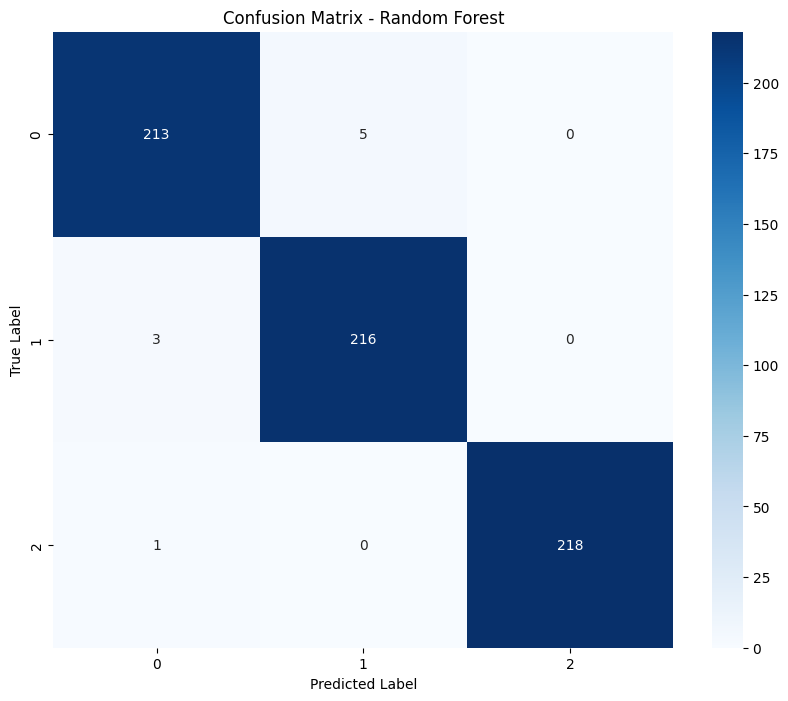


XGBoost Results:
Training accuracy: 0.9941099476439791
Test accuracy: 0.9878048780487805

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       218
           1       0.99      0.98      0.99       219
           2       1.00      1.00      1.00       219

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



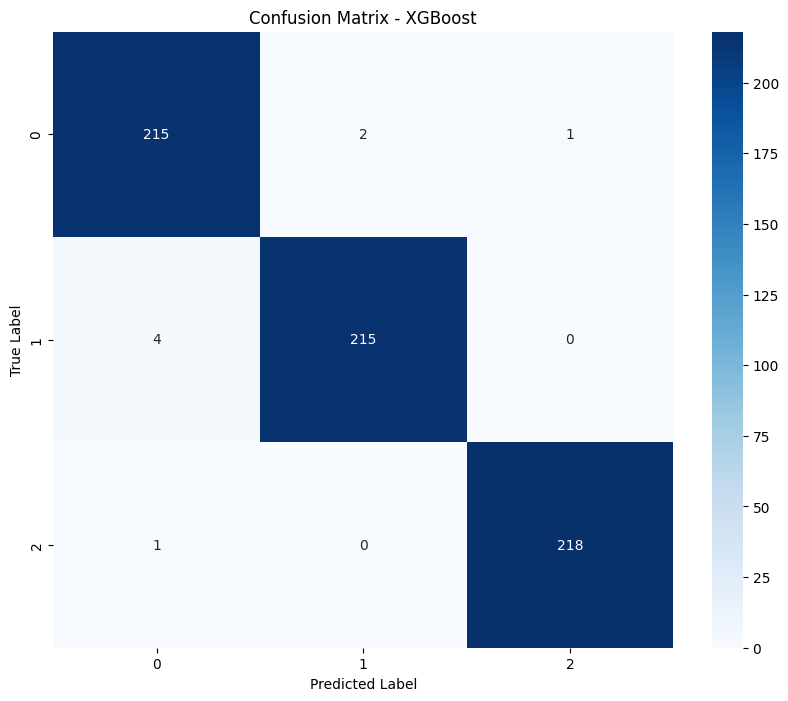

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10222
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 43
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

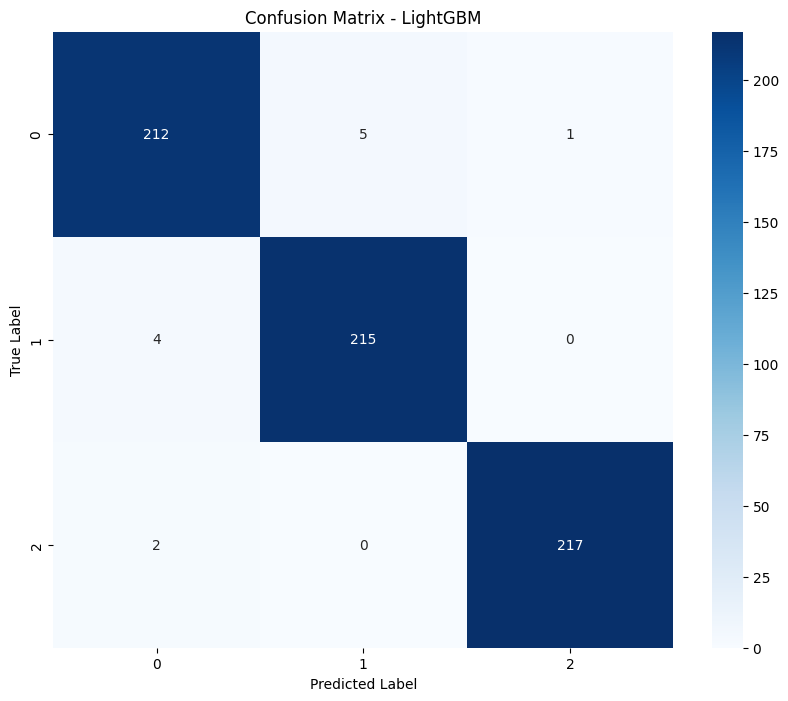

In [111]:
trained_models = {}
for name, model in models.items():
    trained_models[name] = train_and_evaluate_model(
        model, 
        X_train, 
        y_train, 
        X_test, 
        y_test,
        name
    )

In [112]:
print("\nCross-validation Results:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in trained_models.items():
    scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='f1_weighted')
    print(f"{name} CV scores: {scores}")
    print(f"{name} Average CV score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")


Cross-validation Results:
Random Forest CV scores: [0.99313501 0.9816514  0.97714816 0.97022006 0.99082352]
Random Forest Average CV score: 0.983 (+/- 0.017)
XGBoost CV scores: [0.99542329 0.99314279 0.97015549 0.97475134 0.9862317 ]
XGBoost Average CV score: 0.984 (+/- 0.020)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10218
[LightGBM] [Info] Number of data points in the train set: 1747, number of used features: 43
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

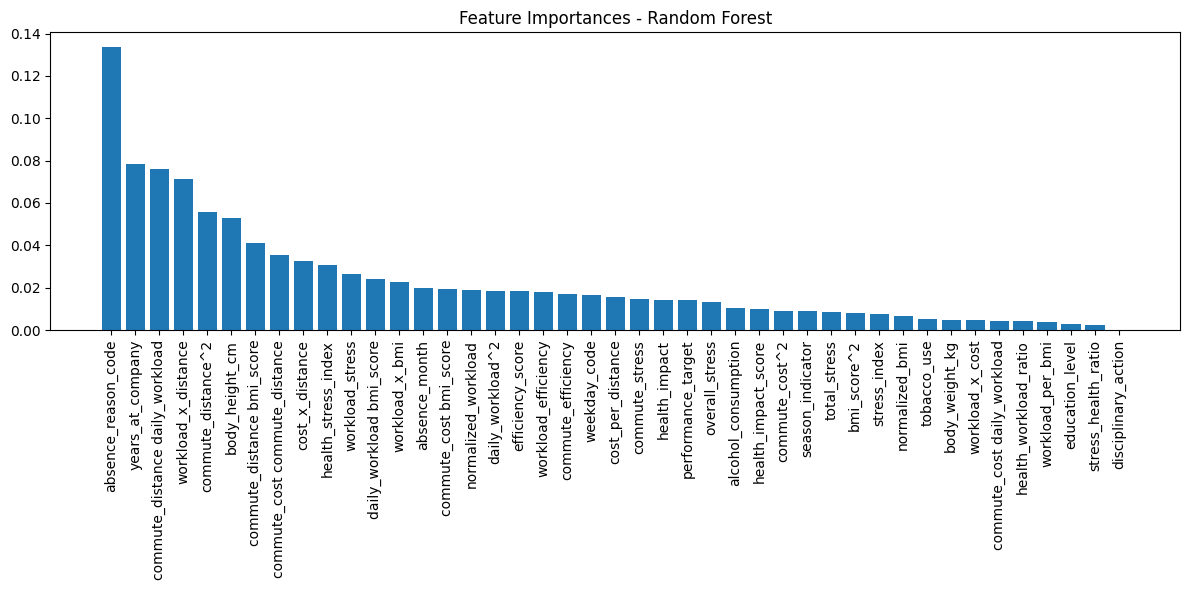

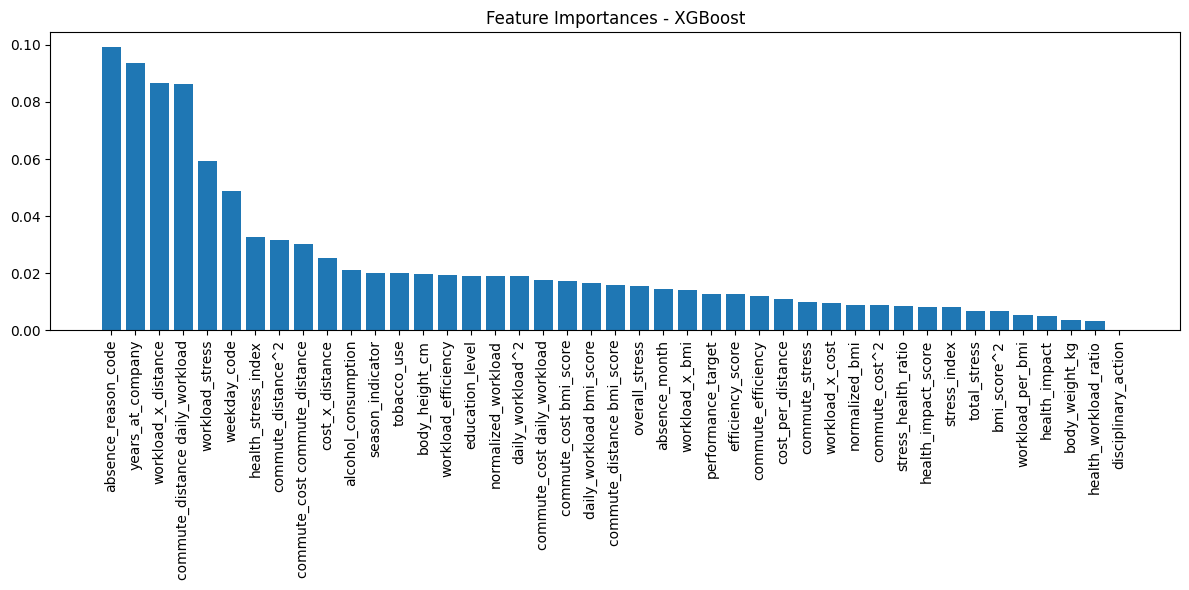

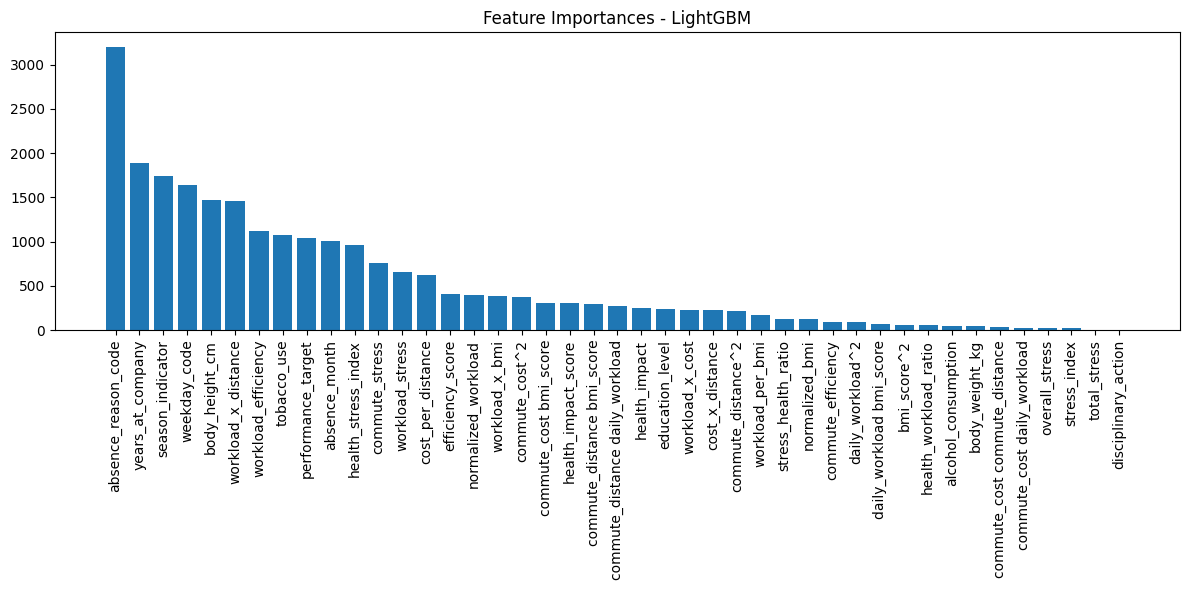

In [113]:

for name, model in trained_models.items():
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(12, 6))
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.title(f'Feature Importances - {name}')
        plt.bar(range(X.shape[1]), importances[indices])
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10222
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 43
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

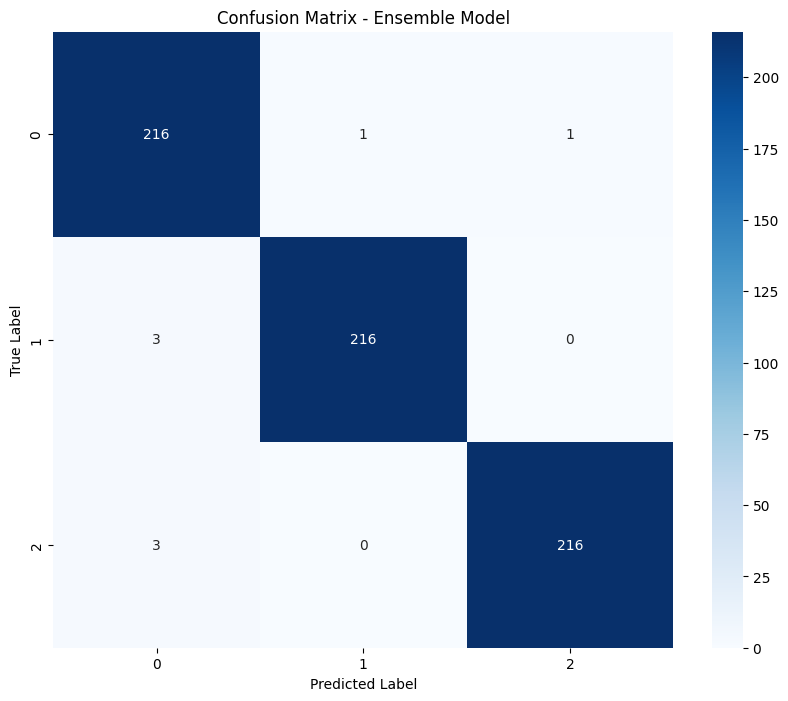

In [114]:

ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in trained_models.items()],
    voting='soft',
    weights=[1.2, 1.0, 1.1] 
)

ensemble_model = train_and_evaluate_model(
    ensemble,
    X_train,
    y_train,
    X_test,
    y_test,
    'Ensemble Model'
)

In [115]:

print("\nFinal Model Comparison:")
for name, model in trained_models.items():
    print(f"\n{name}:")
    print(f"Training accuracy: {model.score(X_train, y_train):.3f}")
    print(f"Test accuracy: {model.score(X_test, y_test):.3f}")
    print(f"classification_report: {classification_report(y_test, model.predict(X_test), zero_division=0)}")

print("\nEnsemble Model:")
print(f"Training accuracy: {ensemble_model.score(X_train, y_train):.3f}")
print(f"Test accuracy: {ensemble_model.score(X_test, y_test):.3f}")
print(f"classification_report: {classification_report(y_test, ensemble_model.predict(X_test), zero_division=0)}")


Final Model Comparison:

Random Forest:
Training accuracy: 0.990
Test accuracy: 0.986
classification_report:               precision    recall  f1-score   support

           0       0.98      0.98      0.98       218
           1       0.98      0.99      0.98       219
           2       1.00      1.00      1.00       219

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656


XGBoost:
Training accuracy: 0.994
Test accuracy: 0.988
classification_report:               precision    recall  f1-score   support

           0       0.98      0.99      0.98       218
           1       0.99      0.98      0.99       219
           2       1.00      1.00      1.00       219

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656


LightGBM:
Training accuracy: 0.991
Test accuracy

In [116]:
import joblib
joblib.dump(ensemble_model, r'C:\Users\Yaswanth Reddy\WorkforceEngagementPrediction\models\ensemble_model.pkl')
joblib.dump(trained_models['XGBoost'], r'C:\Users\Yaswanth Reddy\WorkforceEngagementPrediction\models\XGBoost_model.pkl')
joblib.dump(trained_models['LightGBM'], r'C:\Users\Yaswanth Reddy\WorkforceEngagementPrediction\models\LightGBM_model.pkl')
joblib.dump(trained_models['Random Forest'], r'C:\Users\Yaswanth Reddy\WorkforceEngagementPrediction\models\Random_Forest_model.pkl')


['C:\\Users\\Yaswanth Reddy\\WorkforceEngagementPrediction\\models\\Random_Forest_model.pkl']

In [117]:
def predict_single_employee(employee_data):

    required_features = [
        'absence_reason_code', 'absence_month', 'weekday_code',
        'season_indicator', 'commute_cost', 'commute_distance',
        'years_at_company', 'daily_workload', 'performance_target',
        'disciplinary_action', 'education_level', 'alcohol_consumption',
        'tobacco_use', 'body_weight_kg', 'body_height_cm', 'bmi_score'
    ]

    missing_features = [feat for feat in required_features if feat not in employee_data]
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")
    
    data = pd.DataFrame([{feat: employee_data[feat] for feat in required_features}])

    data = create_advanced_features(data)
    
    model_path = r"C:\Users\Yaswanth Reddy\OneDrive\Documents\Gradious\MLMiniProject\backend\models\ensemble_model.pkl"
    try:
        model = joblib.load(model_path)
    except:
        raise Exception("Model file not found. Please train the model first by running the main() function.")
    

    prediction = model.predict(data)[0]
    probabilities = model.predict_proba(data)[0]
    confidence = probabilities[prediction]
    
    class_descriptions = {
        0: "Very Low absence (0-4 hours)",
        1: "Low absence (4-8 hours)",
        2: "Medium absence (8-16 hours)",
        3: "High absence (>16 hours)"
    }
    
    return {
        "predicted_class": int(prediction),
        "class_description": class_descriptions[prediction],
        "confidence_score": float(confidence)
    }

In [118]:
def create_advanced_features(data):
    numeric_cols = ['commute_cost', 'commute_distance', 'daily_workload', 'bmi_score']
    
    poly = PolynomialFeatures(degree=2, include_bias=False)  
    poly_features = poly.fit_transform(data[numeric_cols])
    
    poly_feature_names = poly.get_feature_names_out(numeric_cols)
    
    poly_df = pd.DataFrame(poly_features[:, len(numeric_cols):], 
                          columns=poly_feature_names[len(numeric_cols):],
                          index=data.index)
    
    data['workload_x_cost'] = data['daily_workload'] * data['commute_cost']
    data['workload_x_distance'] = data['daily_workload'] * data['commute_distance']
    data['cost_x_distance'] = data['commute_cost'] * data['commute_distance']
    data['workload_x_bmi'] = data['daily_workload'] * data['bmi_score']
    data['cost_per_distance'] = data['commute_cost'] / (data['commute_distance'] + 1e-6)
    data['workload_per_bmi'] = data['daily_workload'] / (data['bmi_score'] + 1e-6)
    data['workload_stress'] = data['daily_workload'] * (1 + data['bmi_score']/100)
    data['commute_stress'] = data['commute_cost'] * (1 + data['commute_distance']/100)
    data['normalized_workload'] = (data['daily_workload'] - data['daily_workload'].mean()) / data['daily_workload'].std()
    data['normalized_bmi'] = (data['bmi_score'] - data['bmi_score'].mean()) / data['bmi_score'].std()
    data['stress_index'] = (data['workload_stress'] + data['commute_stress']) / 2
    data['health_impact'] = data['bmi_score'] * (1 + data['daily_workload']/100)
    data['total_stress'] = data['workload_stress'] + data['commute_stress']
    data['health_workload_ratio'] = data['bmi_score'] / (data['daily_workload'] + 1e-6)
    data['commute_efficiency'] = data['commute_cost'] / (data['commute_distance'] + 1e-6)
    data['stress_health_ratio'] = data['total_stress'] / (data['bmi_score'] + 1e-6)
    data['workload_efficiency'] = data['daily_workload'] / (data['commute_cost'] + 1e-6)
    data['health_stress_index'] = data['bmi_score'] * data['total_stress'] / 100
    data['overall_stress'] = (data['workload_stress'] + data['commute_stress'] + data['health_stress_index']) / 3
    data['efficiency_score'] = (data['workload_efficiency'] + data['commute_efficiency']) / 2
    data['health_impact_score'] = data['health_impact'] * (1 + data['stress_health_ratio'])

    data = data.drop(columns=numeric_cols)

    data = pd.concat([data, poly_df], axis=1)
    
    return data

In [35]:
import os

employee_data = {
    'absence_reason_code': 4,
    'absence_month': 1,
    'weekday_code': 1,
    'season_indicator': 1,
    'commute_cost': 50.0,
    'commute_distance': 20.0,
    'years_at_company': 5.0,
    'daily_workload': 10.0,
    'performance_target': 85.0,
    'disciplinary_action': 1,
    'education_level': 2,
    'alcohol_consumption': 0,
    'tobacco_use': 0,
    'body_weight_kg': 70.0,
    'body_height_cm': 175.0,
    'bmi_score': 25.0
}

result = predict_single_employee(employee_data)
print(result)

Exception: Model file not found. Please train the model first by running the main() function.